In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import scipy.optimize as opt
from scipy.optimize import least_squares
import pandas as pd
import random
from sklearn.metrics import r2_score

In [2]:
# Load the Excel file
file_path = "data_v2_02_11_to_05_10.xlsx"
df = pd.read_excel(file_path, usecols=["Timestamp", "SoC(%)", "Battery Current(A)", "Battery Voltage(V)"])

# Display the first few rows to identify columns
print(df.head())

             Timestamp  Battery Voltage(V)  Battery Current(A)  SoC(%)
0  2025-02-10 22:07:00               420.6                0.29      74
1  2025-02-10 22:12:37               420.6                0.29      74
2  2025-02-10 22:18:14               420.6                0.29      74
3  2025-02-10 22:23:51               420.8               -0.04      74
4  2025-02-10 22:29:28               420.8                0.00      74


In [3]:
def R1(a, soc, rr):
    return (a[0] + a[1]*rr + a[2]*(rr**2)) * np.exp(-a[3]*soc) + (a[4] + a[5]*rr + a[6]*(rr**2))

def R2(a, soc, rr):
    return (a[7] + a[8]*rr + a[9]*(rr**2)) * np.exp(-a[10]*soc) + (a[11] + a[12]*rr + a[13]*(rr**2))

def C1(a, soc, rr):
    term1 = -(a[14] + a[15]*rr + a[16]*(rr**2)) * np.exp(-a[17]*soc)
    term2 = (a[18] + a[19]*soc + a[20]*(rr**2))
    return max(term1 + term2, 1e-6)

def V0(a, soc, rr):
    return (a[21] + a[22]*rr + a[23]*(rr**2)) * np.exp(-a[24]*soc) + (a[25] + a[26]*soc + a[27]*(soc**2) + a[28]*(soc**3)) - a[29]*rr + a[30]*(rr**2)

In [4]:
def terminal_voltage_charge(I, t, Q, C, R1, R2, C1, V0):
    voltage = ((Q/C + I*R2) * np.exp(-(t / (R2 * C1)))) + V0 - (I*(R1 + R2))
    return voltage

In [5]:
def objective_function(params, df, Q, C, rr):
    predicted_vals = []
    true_vals = []

    for _, row in df.iterrows():
        x = row["SoC"]
        I = row["Battery Current(A)"]
        t = row["time_diff_sec"]

        p = compute_params(x, rr, params)
        predicted_v = terminal_voltage_charge(I, t, Q, C, p["R1"], max(p["R2"], 1e-3), max(p["C1"], 1e-3), p["V0"])
        predicted_vals.append(predicted_v)
        true_vals.append(row["Battery Voltage(V)"])

    predicted_vals = np.array(predicted_vals)
    true_vals = np.array(true_vals)

    mse = np.mean((true_vals - predicted_vals) ** 2)

    #penalize error spread instead of raw prediction variance
    errors = true_vals - predicted_vals
    spread_penalty = np.var(errors)
    alpha = 0.5

    return mse + alpha * spread_penalty


# Compute resistance, capacitance, and voltage model
def compute_params(soc, rr, params):
    return {
        "R1": R1(a=params, soc=soc, rr=rr),
        "R2": R2(a=params, soc=soc, rr=rr),
        "C1": C1(a=params, soc=soc, rr=rr),
        "V0": V0(a=params, soc=soc, rr=rr)
    }

In [6]:
# Genetic Algorithm (GA)
class GeneticAlgorithm:
    def __init__(self, pop_size=100, generations=100, mutation_rate=0.8):
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.fitness_history = []  # Stores best fitness per generation
        self.lower_bounds = np.full(31, 1e-3)
        self.upper_bounds = np.full(31, 1.0)


    def initialize_population(self, initial_guess):
        return initial_guess


    def evaluate(self, population, df, Q, C, rr):
        return [objective_function(ind, df, Q, C, rr) for ind in population]

    def select_parents(self, population, fitness, tournament_size=3):
        parents = []
        for _ in range(len(population) // 2):
            candidates = random.sample(list(zip(population, fitness)), tournament_size)
            winner = min(candidates, key=lambda x: x[1])[0]
            parents.append(winner)
        return parents


    def crossover(self, parents):
        children = []
        while len(children) + len(parents) < self.pop_size:
            p1, p2 = random.sample(parents, 2)
            pt = len(p1) // 2
            child = np.maximum(np.concatenate([p1[:pt], p2[pt:]]), 0)
            children.append(child)
        return parents + children

    def mutate(self, population, gen=None):
        scale = 0.1 if gen is None else max(0.01, 0.1 * (1 - gen / self.generations))
        for ind in population:
            if random.random() < self.mutation_rate:
                num_genes = 5
                for _ in range(num_genes):
                    i = random.randint(0, len(ind) - 1)
                    ind[i] = max(0, ind[i] + np.random.normal(0, scale))
        return population


    def optimize(self, initial_guess, df, Q, C, rr, plot=True):
        population = self.initialize_population(initial_guess=initial_guess)
        count = 1
        for gen in range(self.generations):
            fitness = self.evaluate(population, df, Q, C, rr)
            best_fitness = min(fitness)  # lower is better (assumes a loss function)
            self.fitness_history.append(best_fitness)

            print(f"Generation: {count}; Best fitness: {best_fitness:.4f}")
            count += 1

            parents = self.select_parents(population, fitness)
            population = self.crossover(parents)
            population = self.mutate(population, gen)

        if plot:
            plt.plot(self.fitness_history, label='Best Fitness')
            plt.xlabel('Generation')
            plt.ylabel('Fitness (lower is better)')
            plt.title('Genetic Algorithm Optimization Progress')
            plt.grid(True)
            plt.legend()
            plt.show()

        return min(population, key=lambda x: objective_function(x, df, Q, C, rr))


Optimized C Value: 1.2000


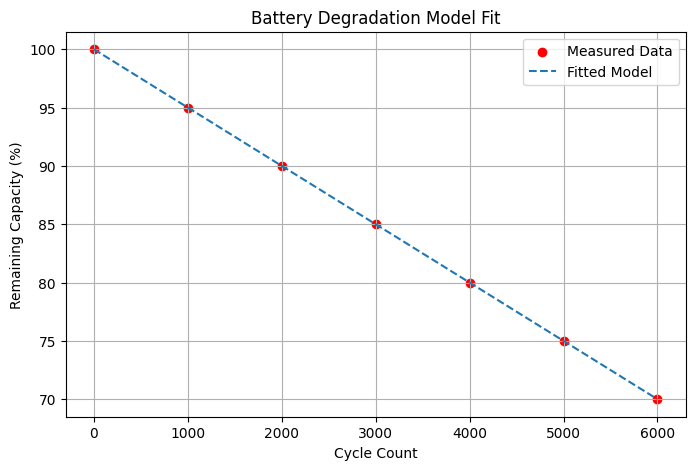

In [7]:
cycles = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000])  # Cycles
capacity = np.array([100, 95, 90, 85, 80, 75, 70])  # Percentage of original capacity

# Constants for the degradation model
R = 8.314  # Universal gas constant (J/mol-K)
T = 298  # Operating temperature (Kelvin)
Ec = 50  # Energy processed during charging (kWh)
Cr = 1.0  # Charge rate (normalized)
Ed = 50  # Energy processed during discharging (kWh)
Q = 100  # Battery capacity (Ah)
Dr = 1.0  # Discharge rate

# Capacity degradation model function
def degradation_model(params, x):
    A, B, C, D = params  # Adjustable coefficients
    return 100 - (A * np.exp((C * Ec * Cr) / (R * T)) + B * np.exp((D * Ed * Q * Dr) / (R * T))) * x

# Error function for optimization
def error_function(params):
    predicted = degradation_model(params, cycles)
    return np.sum((predicted - capacity) ** 2)

# Optimize A, B, C, D to best fit the battery data
initial_guess = [0.1, 0.1, 1.2, 1.5]  # Starting estimates
optimal_params = opt.minimize(error_function, initial_guess, method="L-BFGS-B")

# Extract optimized values
A_opt, B_opt, C_opt, D_opt = optimal_params.x
print(f"Optimized C Value: {C_opt:.4f}")

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(cycles, capacity, label="Measured Data", color="red")
plt.plot(cycles, degradation_model(optimal_params.x, cycles), label="Fitted Model", linestyle="--")
plt.xlabel("Cycle Count")
plt.ylabel("Remaining Capacity (%)")
plt.legend()
plt.title("Battery Degradation Model Fit")
plt.grid()
plt.show()

In [20]:
df["Timestamp"] = pd.to_datetime(df['Timestamp'])
df['time_diff_sec'] = df['Timestamp'].shift(1) - df['Timestamp']
df['time_diff_sec'] = df['time_diff_sec'].dt.total_seconds().abs() // 60
df = df.dropna(subset=["time_diff_sec"])

charging_df = df[df["Battery Current(A)"] < 0].copy().reset_index()
discharging_df = df[df["Battery Current(A)"] > 0].copy().reset_index()

charging_df["SoC"] = charging_df["SoC(%)"] / 100
charging_df["Battery Voltage(V)"] = charging_df["Battery Voltage(V)"] / 8

discharging_df["SoC"] = discharging_df["SoC(%)"] / 100
discharging_df["Battery Voltage(V)"] = discharging_df["Battery Voltage(V)"] / 8

grouped_df = charging_df.groupby("SoC").agg({
    "Battery Voltage(V)": "mean",
    "Battery Current(A)": "mean",
    'time_diff_sec': "mean"
}).reset_index()

grouped_discharging_df = discharging_df.groupby("SoC").agg({
    "Battery Voltage(V)": "mean",
    "Battery Current(A)": "mean",
    'time_diff_sec': "mean"
}).reset_index()

base_individual = np.array([
        7.85231184e-02, 4.40647431e-02, 5.29996992e-02, 5.39618467e+00,
        9.27903476e-03, 9.26349258e-03, 9.22953733e-03, 1.06815413e-01,
        9.96646781e-02, 7.80931383e-02, 6.54827944e+00, 9.20989068e-03,
        9.24046561e-03, 9.20959401e-03, 1.66975752e+00, 9.45711252e-01,
        1.05770358e+00, 6.05011245e-01, 8.02279668e-01, 5.59429726e-01,
        7.18991714e-01, 1.04206319e+01, 1.02679365e+01, 1.01882110e+01,
        9.23302598e-02, 1.03816029e+01, 4.32625090e+00, 6.06022845e-01,
        1.66211626e-01, 1.36376529e-03, 1.01615923e+01
        ])
    
# Generate population with slight random variations
initial_guess_lsm = base_individual + np.random.uniform(-0.5, 0.5, len(base_individual))
initial_guess_lsm = np.maximum(initial_guess_lsm, 0)  # Prevent negative values
initial_guess_ga = []
for _ in range(100):
    mutated_individual = base_individual + np.random.uniform(-0.5, 0.5, len(base_individual))
    mutated_individual = np.maximum(mutated_individual, 0)  # Prevent negative values
    initial_guess_ga.append(mutated_individual)

In [21]:
grouped_df.head(100)

,SoC,Battery Voltage(V),Battery Current(A),time_diff_sec
0,0.19,51.665000,-2.682000,5.000000
1,0.20,52.268750,-4.970000,3.000000
2,0.21,51.918750,-2.665000,4.333333
3,0.22,52.125000,-3.910000,5.000000
4,0.23,51.709375,-0.940000,5.000000
...,...,...,...,...
77,0.96,54.205392,-12.790000,4.862745
78,0.97,54.164750,-11.734800,4.940000
79,0.98,54.325980,-11.724314,4.784314
80,0.99,53.947576,-4.510327,4.871460


In [22]:
grouped_discharging_df.head(100)

,SoC,Battery Voltage(V),Battery Current(A),time_diff_sec
0,0.19,51.330660,0.426604,4.905660
1,0.20,51.462500,0.337407,4.876543
2,0.21,51.543023,0.587442,4.976744
3,0.22,51.568015,0.507353,4.852941
4,0.23,51.685357,0.736857,4.857143
...,...,...,...,...
77,0.96,52.866154,8.711077,4.907692
78,0.97,52.957639,6.265833,4.847222
79,0.98,52.929386,6.536491,4.894737
80,0.99,53.083015,6.513740,4.824427


Generation: 1; Best fitness: 0.8967
Generation: 2; Best fitness: 1.0114
Generation: 3; Best fitness: 0.7038
Generation: 4; Best fitness: 0.8141
Generation: 5; Best fitness: 0.5445
Generation: 6; Best fitness: 0.4654
Generation: 7; Best fitness: 0.6543
Generation: 8; Best fitness: 0.6176
Generation: 9; Best fitness: 0.5942
Generation: 10; Best fitness: 0.5013
Generation: 11; Best fitness: 0.4235
Generation: 12; Best fitness: 0.4326
Generation: 13; Best fitness: 0.2094
Generation: 14; Best fitness: 0.2105
Generation: 15; Best fitness: 0.1992
Generation: 16; Best fitness: 0.2729
Generation: 17; Best fitness: 0.2802
Generation: 18; Best fitness: 0.3921
Generation: 19; Best fitness: 0.1442
Generation: 20; Best fitness: 0.3795
Generation: 21; Best fitness: 0.3294
Generation: 22; Best fitness: 0.3481
Generation: 23; Best fitness: 0.3361
Generation: 24; Best fitness: 0.3115
Generation: 25; Best fitness: 0.3053
Generation: 26; Best fitness: 0.1188
Generation: 27; Best fitness: 0.2539
Generation

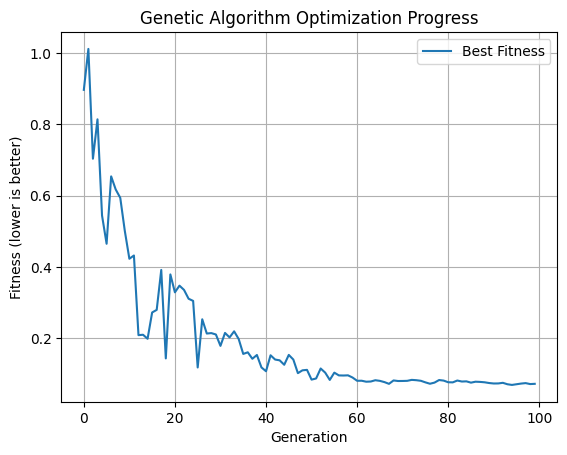

Optimized Parameters (GA): [1.70598105e-01 3.27793548e-03 8.36593630e-02 5.68324572e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.97056439e-03
 1.01811802e-01 3.44717447e-01 5.85016025e+00 0.00000000e+00
 7.28350912e-02 1.29258146e-03 2.01470698e+00 1.82226601e+00
 9.26501933e-01 5.06601671e-01 1.48258810e+00 1.71284137e-01
 9.38472062e-01 1.02342738e+01 1.01055580e+01 1.00883634e+01
 1.28237666e-01 1.00898473e+01 4.40466338e+00 1.35157073e+00
 4.38696962e-01 8.39013017e-02 1.07090282e+01]


In [23]:
# Running GA for charging
ga_optimizer = GeneticAlgorithm()
best_params_ga = ga_optimizer.optimize(initial_guess_ga, grouped_df, Q, C_opt, Cr)
print("Optimized Parameters (GA):", best_params_ga)

In [24]:
# Compute predictions for charging
predicted_voltages_ga_charging = grouped_df.apply(
    lambda row: terminal_voltage_charge(
        I=row["Battery Current(A)"],
        t=row["time_diff_sec"],
        Q=Q,
        C=C_opt,
        **compute_params(row["SoC"], Cr, best_params_ga)
    ),
    axis=1
)

predicted_voltages_ga_charging.head(100)

0     52.133951
1     52.791385
2     52.083500
3     52.404713
4     51.595151
        ...    
77    54.464139
78    54.429108
79    54.475070
80    53.971049
81    53.712732
Length: 82, dtype: float64

In [25]:
actual_voltages = grouped_df["Battery Voltage(V)"]
r2 = r2_score(actual_voltages, predicted_voltages_ga_charging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): 0.8743


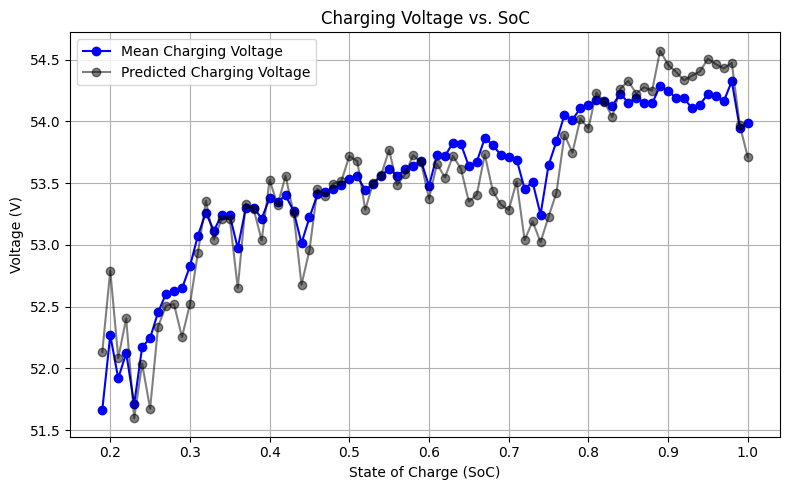

In [26]:

# Create Charging Voltage Plot
plt.figure(figsize=(8, 5))


plt.plot(
    grouped_df["SoC"], 
    grouped_df["Battery Voltage(V)"], 
    marker='o', 
    linestyle='-', 
    label="Mean Charging Voltage", 
    color='blue'
)

plt.plot(
    grouped_df["SoC"], 
    predicted_voltages_ga_charging, 
    color='black',
    marker='o', 
    linestyle='-',
    label="Predicted Charging Voltage", 
    alpha=0.5
)

plt.xlabel("State of Charge (SoC)")
plt.ylabel("Voltage (V)")
plt.title("Charging Voltage vs. SoC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Generation: 1; Best fitness: 1.2480
Generation: 2; Best fitness: 0.4737
Generation: 3; Best fitness: 0.5644
Generation: 4; Best fitness: 0.5551
Generation: 5; Best fitness: 0.6198
Generation: 6; Best fitness: 0.6642
Generation: 7; Best fitness: 0.5698
Generation: 8; Best fitness: 0.4890
Generation: 9; Best fitness: 0.5534
Generation: 10; Best fitness: 0.4359
Generation: 11; Best fitness: 0.3365
Generation: 12; Best fitness: 0.3604
Generation: 13; Best fitness: 0.4076
Generation: 14; Best fitness: 0.4078
Generation: 15; Best fitness: 0.3820
Generation: 16; Best fitness: 0.3983
Generation: 17; Best fitness: 0.2761
Generation: 18; Best fitness: 0.2761
Generation: 19; Best fitness: 0.2692
Generation: 20; Best fitness: 0.2701
Generation: 21; Best fitness: 0.2494
Generation: 22; Best fitness: 0.1862
Generation: 23; Best fitness: 0.1810
Generation: 24; Best fitness: 0.1766
Generation: 25; Best fitness: 0.1302
Generation: 26; Best fitness: 0.1699
Generation: 27; Best fitness: 0.1007
Generation

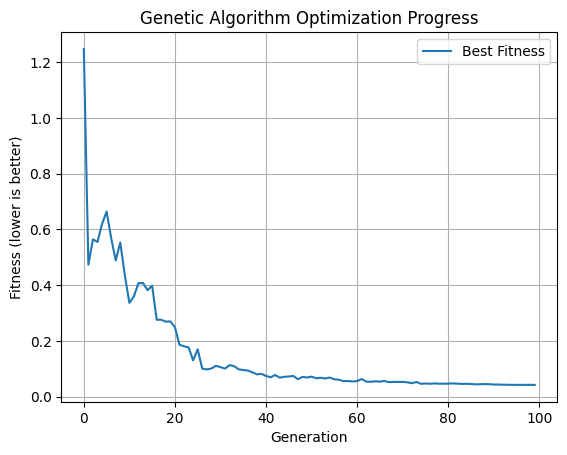

Optimized Parameters (GA): [0.00000000e+00 9.01591001e-03 0.00000000e+00 5.27468320e+00
 5.82497178e-03 5.81835510e-03 9.01003121e-03 1.25696227e-02
 1.09433008e-01 3.48785011e-02 6.31448175e+00 7.99070000e-03
 0.00000000e+00 0.00000000e+00 2.07316297e+00 5.62212724e-01
 5.59403481e-01 3.90620040e-01 3.48844403e-01 5.32212320e-01
 5.31199350e-01 1.03233869e+01 1.00525089e+01 1.06757904e+01
 8.07278261e-02 1.05020846e+01 3.75462512e+00 0.00000000e+00
 2.61804928e-01 1.79741474e-01 1.04145198e+01]


In [27]:
# Running GA for discharging
ga_optimizer_discharging = GeneticAlgorithm()
best_params_ga_discharging = ga_optimizer_discharging.optimize(initial_guess_ga, grouped_discharging_df, Q, C_opt, Dr)
print("Optimized Parameters (GA):", best_params_ga_discharging)

In [28]:
# Compute predictions for discharging
predicted_voltages_ga_discharging = grouped_discharging_df.apply(
    lambda row: terminal_voltage_charge(
        I=row["Battery Current(A)"],
        t=row["time_diff_sec"],
        Q=Q,
        C=C_opt,
        **compute_params(row["SoC"], Dr, best_params_ga_discharging)
    ),
    axis=1
)

predicted_voltages_ga_discharging.head(100)

0     51.997284
1     52.018552
2     52.014421
3     52.034934
4     52.033934
        ...    
77    53.055837
78    53.148742
79    53.162879
80    53.185701
81    53.312826
Length: 82, dtype: float64

In [29]:
actual_voltages = grouped_discharging_df["Battery Voltage(V)"]
r2 = r2_score(actual_voltages, predicted_voltages_ga_discharging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): 0.8356


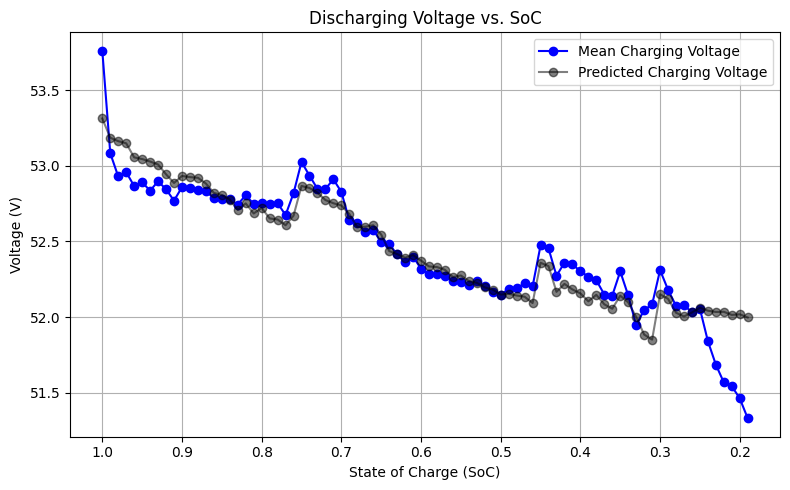

In [30]:
plt.figure(figsize=(8, 5))

# Sort the DataFrame by SoC in descending order
sorted_df = grouped_discharging_df.sort_values(by="SoC", ascending=False)

plt.plot(
    sorted_df["SoC"], 
    sorted_df["Battery Voltage(V)"], 
    marker='o', 
    linestyle='-', 
    label="Mean Charging Voltage", 
    color='blue'
)

plt.plot(
    sorted_df["SoC"], 
    predicted_voltages_ga_discharging[::-1],  # Reverse the predicted voltages list
    color='black',
    marker='o', 
    linestyle='-',
    label="Predicted Charging Voltage", 
    alpha=0.5
)

plt.xlabel("State of Charge (SoC)")
plt.ylabel("Voltage (V)")
plt.title("Discharging Voltage vs. SoC")
plt.legend()
plt.grid(True)

# Reverse the x-axis to display from 1 to 0
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()


##LSM

In [31]:
# Running LSM for charging
result_lsm = least_squares(objective_function, initial_guess_lsm, args=(grouped_df, Q, C_opt, Cr,), bounds=(0, np.inf))
best_params_lsm = result_lsm.x

print("Optimized Parameters (LSM):", best_params_lsm)

Optimized Parameters (LSM): [5.94991727e-02 9.56177277e-02 7.29272469e-02 4.72256652e+00
 6.55060510e-03 6.55060510e-03 6.55060510e-03 9.74939217e-02
 1.00578544e-01 1.71485829e-11 6.39708360e+00 1.41337395e-02
 6.55060510e-03 6.55060510e-03 2.06890744e+00 6.97901998e-01
 9.80816378e-01 1.06777288e+00 3.08976049e-01 7.61979323e-01
 6.80986080e-01 1.04616777e+01 9.87887325e+00 9.97831368e+00
 7.26620748e-02 1.09583778e+01 4.18404546e+00 3.84533265e-01
 1.32776449e-01 2.29307150e-02 1.00261082e+01]


In [32]:
# Compute predictions
predicted_voltages_lsm = grouped_df.apply(
    lambda row: terminal_voltage_charge(
        I=row["Battery Current(A)"],
        t=row["time_diff_sec"],
        Q=Q,
        C=C_opt,
        **compute_params(row["SoC"], Cr, best_params_lsm)
    ),
    axis=1
)

predicted_voltages_lsm.head(100)

0     52.207122
1     52.643881
2     52.206265
3     52.428514
4     51.921394
        ...    
77    54.362592
78    54.340880
79    54.371407
80    54.046586
81    53.880650
Length: 82, dtype: float64

In [33]:
actual_voltages = grouped_df["Battery Voltage(V)"]
r2 = r2_score(actual_voltages, predicted_voltages_lsm)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): 0.9506


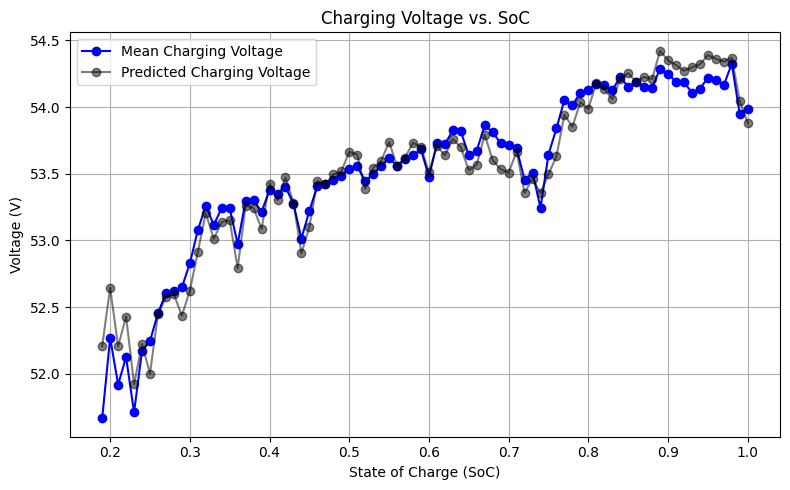

In [34]:
# Create Charging Voltage Plot
plt.figure(figsize=(8, 5))


plt.plot(
    grouped_df["SoC"], 
    grouped_df["Battery Voltage(V)"], 
    marker='o', 
    linestyle='-', 
    label="Mean Charging Voltage", 
    color='blue'
)

plt.plot(
    grouped_df["SoC"], 
    predicted_voltages_lsm, 
    color='black',
    marker='o', 
    linestyle='-',
    label="Predicted Charging Voltage", 
    alpha=0.5
)

plt.xlabel("State of Charge (SoC)")
plt.ylabel("Voltage (V)")
plt.title("Charging Voltage vs. SoC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Running LSM for discharging
result_lsm = least_squares(objective_function, initial_guess_lsm, args=(grouped_df, Q, C_opt, Dr,), bounds=(0, np.inf))
best_params_lsm_discharging = result_lsm.x

print("Optimized Parameters (LSM):", best_params_lsm_discharging)

Optimized Parameters (LSM): [5.94991727e-02 9.56177277e-02 7.29272469e-02 4.72256652e+00
 6.55060510e-03 6.55060510e-03 6.55060510e-03 9.74939217e-02
 1.00578544e-01 1.71485829e-11 6.39708360e+00 1.41337395e-02
 6.55060510e-03 6.55060510e-03 2.06890744e+00 6.97901998e-01
 9.80816378e-01 1.06777288e+00 3.08976049e-01 7.61979323e-01
 6.80986080e-01 1.04616777e+01 9.87887325e+00 9.97831368e+00
 7.26620748e-02 1.09583778e+01 4.18404546e+00 3.84533265e-01
 1.32776449e-01 2.29307150e-02 1.00261082e+01]


In [36]:
# Compute predictions
predicted_voltages_lsm_discharging = grouped_discharging_df.apply(
    lambda row: terminal_voltage_charge(
        I=row["Battery Current(A)"],
        t=row["time_diff_sec"],
        Q=Q,
        C=C_opt,
        **compute_params(row["SoC"], Dr, best_params_lsm_discharging)
    ),
    axis=1
)

predicted_voltages_lsm_discharging.head(100)

0     51.589758
1     51.631919
2     51.610534
3     51.650797
4     51.637447
        ...    
77    53.292643
78    53.447631
79    53.467669
80    53.502388
81    53.714229
Length: 82, dtype: float64

In [37]:
actual_voltages = grouped_discharging_df["Battery Voltage(V)"]
r2 = r2_score(actual_voltages, predicted_voltages_lsm_discharging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): 0.2742


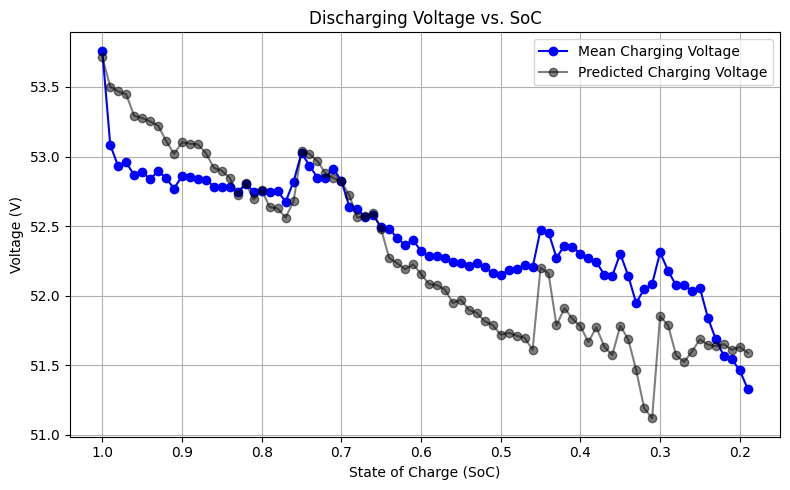

In [38]:
plt.figure(figsize=(8, 5))

# Sort the DataFrame by SoC in descending order
sorted_df = grouped_discharging_df.sort_values(by="SoC", ascending=False)

plt.plot(
    sorted_df["SoC"], 
    sorted_df["Battery Voltage(V)"], 
    marker='o', 
    linestyle='-', 
    label="Mean Charging Voltage", 
    color='blue'
)

plt.plot(
    sorted_df["SoC"], 
    predicted_voltages_lsm_discharging[::-1],  # Reverse the predicted voltages list
    color='black',
    marker='o', 
    linestyle='-',
    label="Predicted Charging Voltage", 
    alpha=0.5
)

plt.xlabel("State of Charge (SoC)")
plt.ylabel("Voltage (V)")
plt.title("Discharging Voltage vs. SoC")
plt.legend()
plt.grid(True)

# Reverse the x-axis to display from 1 to 0
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()